### Data Processing & Feature Engineering

In [1]:
import pandas as pd

ten_minute_df = pd.read_csv("jena_climate_2009_2016.csv")

In [25]:
hourly_df = ten_minute_df[5::6]

In [26]:
hourly_df.loc[:, 'timestamp'] = pd.to_datetime(hourly_df['Date Time'])
hourly_df.loc[:, 'year'] = hourly_df['timestamp'].dt.year
hourly_df.loc[:, 'month'] = hourly_df['timestamp'].dt.month
hourly_df.loc[:, 'day'] = hourly_df['timestamp'].dt.day
hourly_df.loc[:, 'hour'] = hourly_df['timestamp'].dt.hour


<ipython-input-26-a063bfd26031>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df.loc[:, 'timestamp'] = pd.to_datetime(hourly_df['Date Time'])
<ipython-input-26-a063bfd26031>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df.loc[:, 'year'] = hourly_df['timestamp'].dt.year
<ipython-input-26-a063bfd26031>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [16]:
hourly_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),timestamp,year,month,day,hour
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,2009-01-01 01:00:00,2009,1,1,1
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,2009-01-01 02:00:00,2009,1,1,2
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,2009-01-01 03:00:00,2009,1,1,3
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,2009-01-01 04:00:00,2009,1,1,4
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,2009-01-01 05:00:00,2009,1,1,5


<Axes: xlabel='Date Time'>

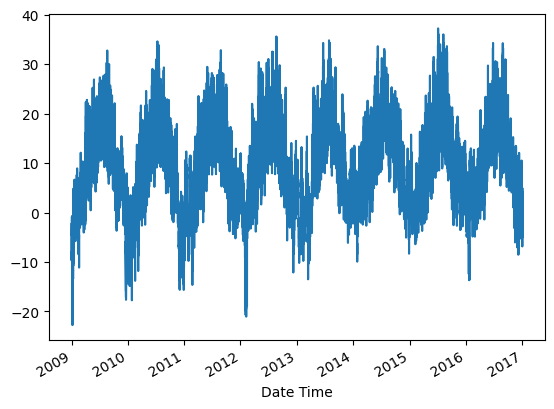

In [ ]:
temp = hourly_df['T (degC)']
temp.plot()

In [17]:
hourly_df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'timestamp', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [27]:
hourly_df = hourly_df[['Date Time', 'p (mbar)', 'T (degC)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'hour', 'day', 'year', 'month']]
hourly_df = hourly_df.rename(columns={'p (mbar)': 'p', 'T (degC)':'temp', 'Tdew (degC)': 'tdew',
       'rh (%)': 'rh', 'VPmax (mbar)': 'vpm'})

In [9]:
hourly_df.head()

nan_count = hourly_df.isna().sum().sum()
print(nan_count)

0


In [83]:
train_df = hourly_df[:60000]
valid_df = hourly_df[60000:65000]
test_df = hourly_df[65000:]

In [84]:
def create_XY(df, multi=True):
    X = df[['temp', 'tdew', 'vpm', 'hour', 'day', 'month', 'year']]
    Y = df[['temp']]
    if multi:
      return X,Y
    return Y,Y

In [85]:
X_train, Y_train = create_XY(train_df)
X_valid, Y_valid = create_XY(valid_df)
X_test, Y_test = create_XY(test_df)

In [86]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train)

X_valid, Y_valid = x_scaler.transform(X_valid), y_scaler.transform(Y_valid)
X_test, Y_test = x_scaler.transform(X_test), y_scaler.transform(Y_test)

In [32]:
import numpy as np
import torch

def build_feature_target_tensors(X, Y, input_window, pred_window):
    """
    Create input and output sequences for model training and return them as PyTorch tensors.

    :param X: 2D numpy array where rows are time steps and columns are features, including 'temp'.
    :param Y: 1D numpy array of target variable (temperature), extracted as Y = X[:, temp_index].
    :param input_window: Number of days to use as input sequences.
    :param pred_window: Number of days to predict.

    :return: X_tensor, Y_tensor - Tensors of input sequences and corresponding target sequences.
    """

    input_hours = input_window * 24
    prediction_hours = pred_window * 24

    assert X.shape[0] == Y.shape[0], "X and Y must have the same number of rows."

    X_sequences, Y_sequences = [], []

    for i in range(0, X.shape[0] - input_hours - prediction_hours + 1, 24):
        x_sequence = X[i:i+input_hours]
        y_sequence = Y[i+input_hours:i+input_hours+prediction_hours]

        X_sequences.append(x_sequence)
        Y_sequences.append(y_sequence)

    # Convert the lists of sequences to numpy arrays and then to PyTorch tensors
    X_tensor = torch.tensor(np.array(X_sequences), dtype=torch.float)
    Y_tensor = torch.tensor(np.array(Y_sequences), dtype=torch.float)

    return X_tensor, Y_tensor


In [33]:
# given input_window days of feature data, make a prediction for temp (hourly) for the next pred_window days
input_window = 7 #(7 * 24)
pred_window = 1 #(24)

In [87]:
X_train_tensor, Y_train_tensor = build_feature_target_tensors(X_train, Y_train, input_window, pred_window)
X_valid_tensor, Y_valid_tensor = build_feature_target_tensors(X_valid, Y_valid, input_window, pred_window)
X_test_tensor, Y_test_tensor = build_feature_target_tensors(X_test, Y_test, input_window, pred_window)

### Model Architecture & Training

In [35]:
import torch
import torch.nn as nn
import math

class Transformer(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, output_seq_len=168):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.output_seq_len = output_seq_len
        self.embedding = nn.Linear(num_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, output_seq_len)

    def forward(self, src):
        # src shape: (batch_size, seq_len, num_features)

        # Embedding + positional encoding
        src = self.embedding(src) * math.sqrt(self.d_model)

        # Pass through the transformer encoder
        encoded_output = self.transformer_encoder(src)

        # We take the last timestep output and pass it through the output linear layer
        # The output linear layer will output one value per future timestep, total of output_seq_len values
        output = self.output_layer(encoded_output[:, -1, :])

        # The output shape is (batch_size, output_seq_len), where output_seq_len is 168 for a week
        return output

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [98]:
num_features = 7
d_model = 96
nhead = 6
num_layers = 3
dim_feedforward = 512
dropout = 0.2
output_seq_len = pred_window * 24 #1 day worth of predictions

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim

model = Transformer(num_features, d_model, nhead, num_layers, dim_feedforward, dropout, output_seq_len)
model.to(device)

criterion = nn.HuberLoss(delta=0.05)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

num_epochs = 75

batch_size = 36
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = (Y_train_tensor.to(device)).squeeze(-1)
X_valid_tensor = X_valid_tensor.to(device)
Y_valid_tensor = (Y_valid_tensor.to(device)).squeeze(-1)

model.train()  # Set the model to training mode

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i + batch_size]
        Y_batch = Y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(X_train_tensor)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        Y_val_pred = model(X_valid_tensor)
        val_loss = criterion(Y_val_pred, Y_valid_tensor)
        valid_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch 1/75, Training Loss: 0.0094, Validation Loss: 0.0041
Epoch 2/75, Training Loss: 0.0064, Validation Loss: 0.0032
Epoch 3/75, Training Loss: 0.0053, Validation Loss: 0.0028
Epoch 4/75, Training Loss: 0.0046, Validation Loss: 0.0027
Epoch 5/75, Training Loss: 0.0040, Validation Loss: 0.0027
Epoch 6/75, Training Loss: 0.0037, Validation Loss: 0.0026
Epoch 7/75, Training Loss: 0.0035, Validation Loss: 0.0025
Epoch 8/75, Training Loss: 0.0033, Validation Loss: 0.0024
Epoch 9/75, Training Loss: 0.0031, Validation Loss: 0.0027
Epoch 10/75, Training Loss: 0.0029, Validation Loss: 0.0026
Epoch 11/75, Training Loss: 0.0028, Validation Loss: 0.0026
Epoch 12/75, Training Loss: 0.0026, Validation Loss: 0.0026
Epoch 13/75, Training Loss: 0.0025, Validation Loss: 0.0027
Epoch 14/75, Training Loss: 0.0024, Validation Loss: 0.0027
Epoch 15/75, Training Loss: 0.0023, Validation Loss: 0.0023
Epoch 16/75, Training Loss: 0.0024, Validation Loss: 0.0022
Epoch 17/75, Training Loss: 0.0024, Validation Lo

In [75]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    plt.title(f'Loss Curves: {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

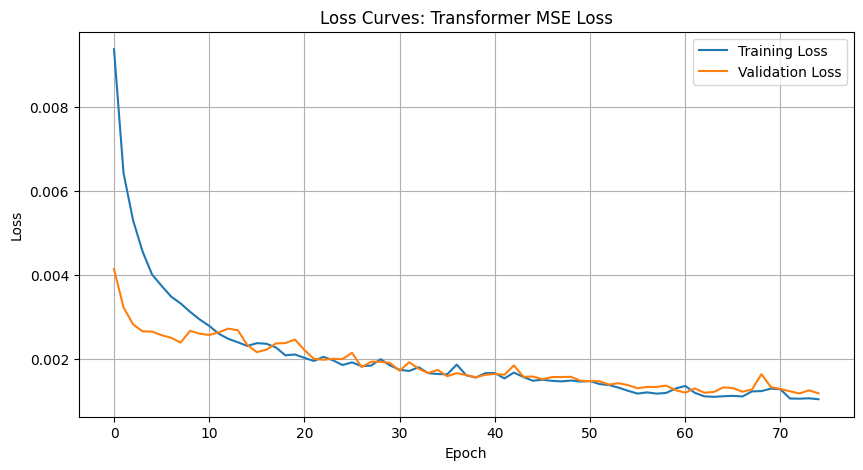

In [102]:
plot_loss_curves(train_losses, valid_losses, "Transformer MSE Loss")

### Model Evaluation and Visualization

In [103]:
torch.save(model.state_dict(), "multi_transformer_state_dict.pth")

In [104]:
tformer = Transformer(num_features, d_model, nhead, num_layers, dim_feedforward, dropout, output_seq_len)
tformer.load_state_dict(torch.load("multi_transformer_state_dict.pth"))
tformer.eval()

Transformer(
  (embedding): Linear(in_features=7, out_features=96, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=96, out_features=24, bias=True)
)

In [105]:
model = tformer

In [106]:
import torch.nn as nn
import torch

# X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.squeeze(-1)
criterion = nn.HuberLoss(delta=0.05)
with torch.no_grad():
  Y_pred = model(X_test_tensor)
  test_loss = criterion(Y_pred, Y_test_tensor)

print(f"Test MSE Loss: {test_loss.item()}")

Test MSE Loss: 0.0019026551162824035


In [81]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, X_test, Y_test, y_scaler):
    model.eval()

    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        with torch.no_grad():
          for i in range(len(X_test)):
              # Assuming X_test is already on the appropriate device and in the correct format
              single_prediction = model(X_test[i].unsqueeze(0))  # Get prediction for the ith test sequence

              # Store predictions and actual values
              all_predictions.append(single_prediction.squeeze(0))  # Squeeze to remove batch dimension if it exists
              all_actuals.append(Y_test[i])

    all_predictions_np = np.array(all_predictions)
    all_actuals_np = np.array(all_actuals)

    all_predictions_rescaled = y_scaler.inverse_transform(all_predictions_np.reshape(-1, 1)).flatten()
    all_actuals_rescaled = y_scaler.inverse_transform(all_actuals_np.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(all_actuals_rescaled, label='Actuals')
    plt.plot(all_predictions_rescaled, label='Predictions')
    plt.title('Test Set Predictions vs. Actuals (Rescaled)')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()


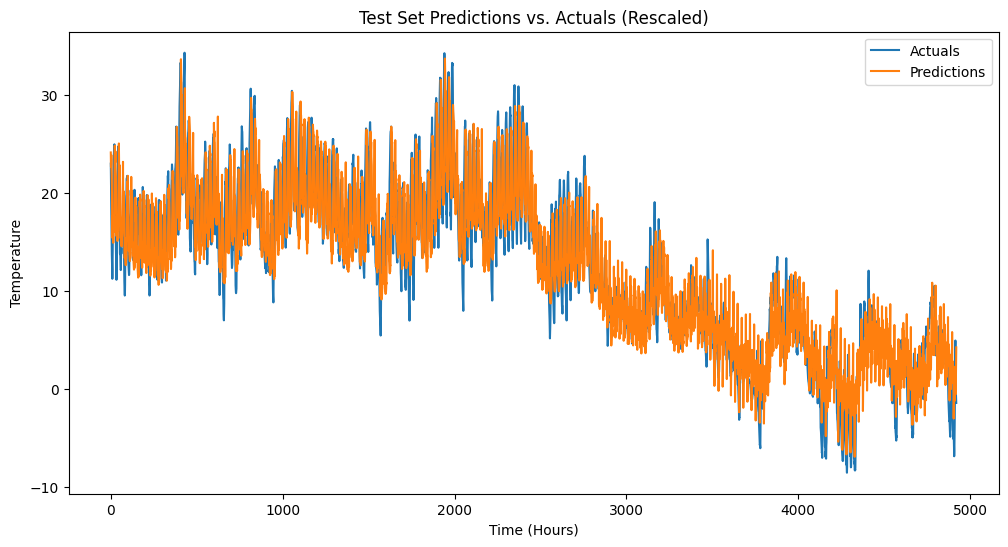

In [107]:
plot_predictions(model, X_test_tensor, Y_test_tensor, y_scaler)